# CICIDS2017 Output Notebook

Defining imports. Please comment the last two lines in case of incomplete or no *latexmk* installation.

In [1]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from intellect.io import load
from collections import Counter

import main as cmain
import pandas as pd
import numpy as np
import matplotlib as mpl
from intellect.scoring import compute_metric_incremental
from matplotlib.axes import Axes
from matplotlib.ticker import FormatStrFormatter

plt.rcParams.update({'text.usetex' : True,
          'font.size': 14,
          "font.family": "sans-serif",
          "font.sans-serif": "Helvetica",
          'figure.figsize': (6.4,4)})

In [2]:
# parameters

CONFIG_PATH = "./config_cicids2017.json"
DEFAULT_SEED = 42

Loading configuration and test portion of dataset.

In [3]:
config = cmain.Config(**load(CONFIG_PATH))

In [4]:
_, test_ds = cmain._load_dataset(config.dataset, config.label, config.train_size)

## Pruning Advantages

This part shows the pruning advantages in terms of both Inference Time and Memory occupation of each model.

The original model is indicated in the Table as *Pruning Ratio 0.0*, while all the other present a different ratio.

In [12]:
def get_memory(n_input, n_hid_units, n_layers, data_size=8):
    coefs = data_size* ( (n_input * n_hid_units) + (n_hid_units*n_hid_units*n_layers) + n_hid_units)
    intercepts = data_size * (n_hid_units*(n_layers+1)+1)
    return (coefs + intercepts)*2 / 1024

m_normal = load(f"{config.dataset_name}_output/seed_{DEFAULT_SEED}_output/evaluation_full.json")
v_normal = get_memory(test_ds.n_features, config.hidden_units, config.hidden_layers)
df = pd.DataFrame(columns=["Prune Ratio", "Inference Time (ns)", "Memory (KB)"])
#df.loc[len(df)] = ["0.0", test_ds.n_samples/np.mean(m_normal) * 10**9, v_normal]
df.loc[len(df)] = ["0.0", np.mean(m_normal)/test_ds.n_samples, v_normal]
for p in config.pruning_amounts:
    m_pruned = load(f"{config.dataset_name}_output/seed_{DEFAULT_SEED}_output/evaluation_pruned_{p}.json")
    new_hidden_units = int(config.hidden_units * (1-p))
    v_pruned = get_memory(test_ds.n_features, new_hidden_units, config.hidden_layers)
    df.loc[len(df)] = [f"{p}", np.mean(m_pruned)/test_ds.n_samples, v_pruned]
df.to_latex(f"{config.dataset_name}_output/seed_{DEFAULT_SEED}_output/evaluation.tex", index=False, float_format="{:0.0f}".format)
df

,Prune Ratio,Inference Time (ns),Memory (KB)
0,0.0,1467.478978,281.015625
1,0.2,1095.034601,182.500000
2,0.5,612.008131,76.515625
3,0.8,238.459905,13.703125


## Feature Importance 

This section plots the relevance of the features in the dataset.

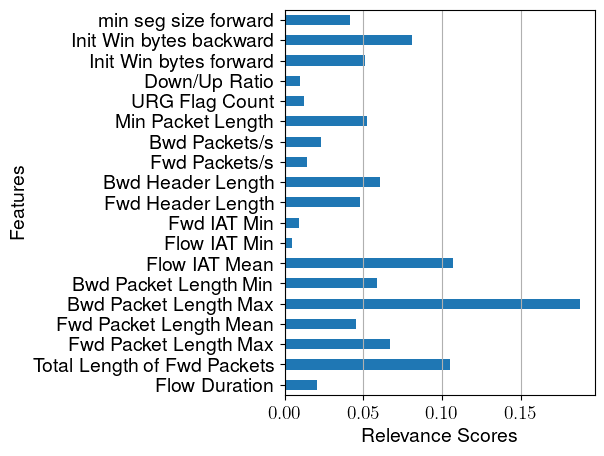

In [10]:
data = pd.DataFrame(load(f"{config.dataset_name}_output/seed_{DEFAULT_SEED}_output/feature_importance_random_forest.json"), index=[0])
data =  data.rename(mapper=lambda x: x.replace("_", " "), axis=1)
fig, ax = plt.subplots(figsize=(4,5))
data.T.plot.barh(legend=False, ylabel="Features", xlabel="Relevance Scores", ax=ax);
ax.grid(axis="x")
fig.savefig(f"{config.dataset_name}_output/seed_{DEFAULT_SEED}_output/featureImportanceRF.pdf", bbox_inches='tight')

## Datadrift

Here we demonstrated whether there are or not data drifts in the current dataset. For each feature, we plot the drifts detected during the test with the *ADWIN* algorithm.

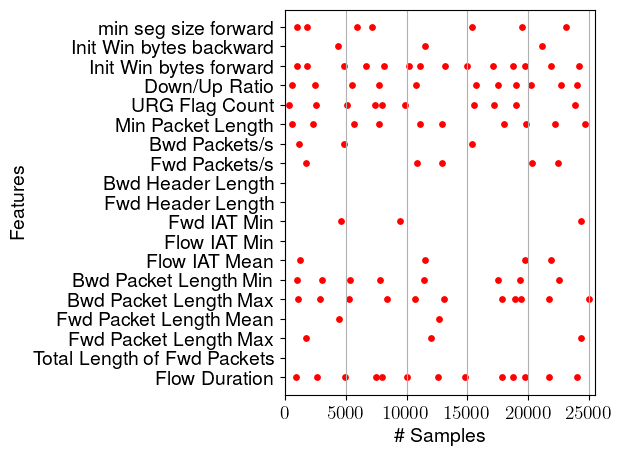

In [9]:
v = load(f"{config.dataset_name}_output/seed_{DEFAULT_SEED}_output/ADWIN.json")
fig, ax = plt.subplots(figsize=(4,5))
for ii, vv in enumerate(test_ds.X.columns, 1):
   if vv not in v:
      continue
   ax.scatter(x=v[vv], y=[ii for _ in range(len(v[vv]))], c="r", s=15)
ax.set_yticks(range(1, 1 + test_ds.n_features))
ax.set_xlim(right=test_ds.n_samples)
ax.set_yticklabels([x.replace("_", " ") for x in test_ds.X.columns.values])
ax.set_xlabel("\# Samples")
ax.set_ylabel("Features");
ax.set_xlim(left=0)
ax.grid(axis="x", which="both")
ax.set_xticks([0, 5000, 10000, 15000, 20000, 25000])
fig.savefig(f"{config.dataset_name}_output/seed_{DEFAULT_SEED}_output/ADWIN.pdf", bbox_inches='tight')

## Test results

Here we present the results of the tests.

At first, we print two tables reporting the global metrics obtained as the average among all the runs.

In [10]:
def wrap_prune_ratios_table(save_name: str, test_name, is_retrain=False):
    f_df: pd.DataFrame = None
    for seed in config.seeds:
        for amount in [0] + config.pruning_amounts:
            if not amount:
                tmp_name = f"{save_name}/seed_{seed}_output/{test_name}_test_incremental"
            else:
                tmp_name = f"{save_name}/seed_{seed}_output/{test_name}{'_' if not is_retrain else '_retrain_'}prune_{amount}_test_incremental"
            df: pd.DataFrame = load(tmp_name + ".csv", index_col=0)
            df["Prune Ratio"] = str(amount)
            f_df = pd.concat((f_df, df))
    final: pd.DataFrame = f_df.drop(index=["After OL"], columns=["Drifts"])
    final["Drift Aware"] = final.index
    final["Drift Aware"] = final["Drift Aware"].apply(lambda x: "No" if "Without" in x else "Yes")
    x = final.groupby(["Prune Ratio", "Drift Aware"]).mean()
    x.to_latex(f"{save_name}/{test_name}_diff.tex", float_format="{:0.3f}".format)
    return x

tl_df = wrap_prune_ratios_table(f"{config.dataset_name}_output", "tl_train", is_retrain=False);
ol_df = wrap_prune_ratios_table(f"{config.dataset_name}_output", "ol_train", is_retrain=False);
display(tl_df, ol_df)

Accuracy    Recall  Precision        F1
Prune Ratio Drift Aware                                         
0           No           0.879658  0.337455   0.910492  0.484441
            Yes          0.979494  0.930841   0.948937  0.939769
0.2         No           0.875961  0.317699   0.895437  0.458204
            Yes          0.979305  0.931028   0.947721  0.939265
0.5         No           0.715741  0.440046   0.349284  0.340407
            Yes          0.972982  0.910535   0.930970  0.920550
0.8         No           0.207548  0.960491   0.174308  0.291289
            Yes          0.956050  0.875977   0.870220  0.872853

Accuracy    Recall  Precision        F1
Prune Ratio Drift Aware                                         
0           No           0.830478  0.013525   0.958202  0.026386
            Yes          0.977925  0.924245   0.946071  0.935021
0.2         No           0.830478  0.013525   0.958202  0.026386
            Yes          0.977925  0.924245   0.946071  0.935021
0.5         No           0.830119  0.011405   0.755203  0.022157
            Yes          0.974898  0.916783   0.935928  0.926209
0.8         No           0.713654  0.180160   0.052617  0.059633
            Yes          0.960873  0.878647   0.892231  0.885284

Here we plot such averaged metrics incrementally, as soon as a new samples is handled by the model.

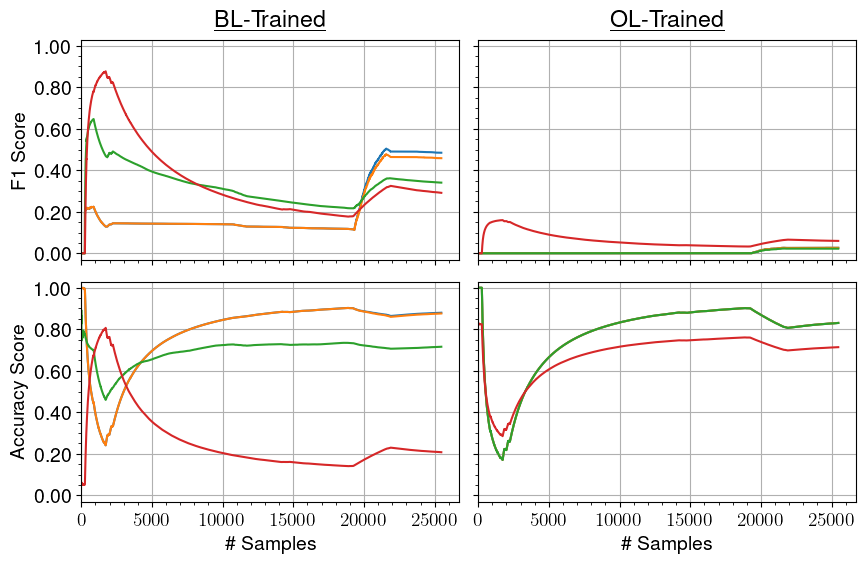

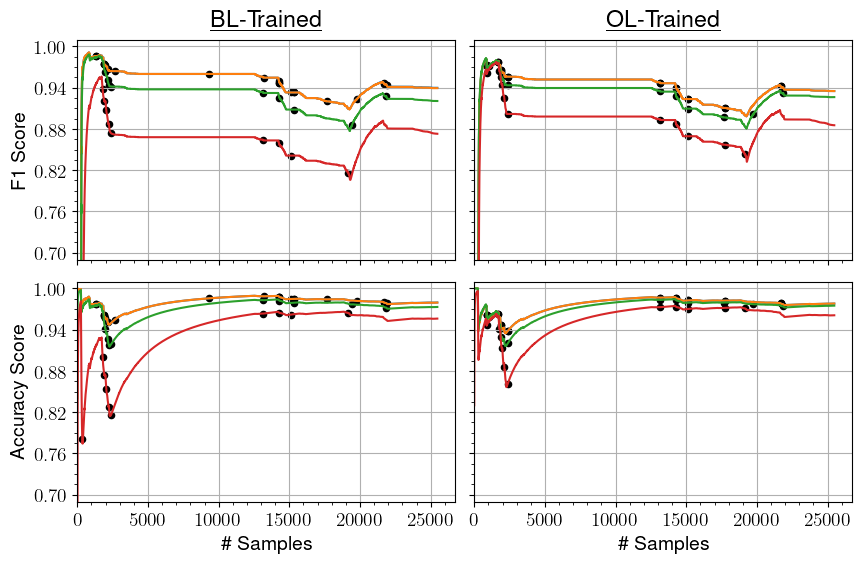

<Figure size 1920x1200 with 0 Axes>

In [8]:
# plot results of the pruning
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6), sharex=True, sharey=True)
fig2, axes2 = plt.subplots(nrows=2, ncols=2, figsize=(10,6), sharex=True, sharey=True)
axes: list[Axes]
for i, name in enumerate(["tl_train", "ol_train"]):
    for amount in [0] + config.pruning_amounts:
        mean_with1 = []
        mean_without1 = []
        mean_with2 = []
        mean_without2 = []
        cdrifts = []
        for seed in config.seeds:
            if not amount:
                tmp_name = f"{config.dataset_name}_output/seed_{seed}_output/{name}_test_incremental"
            else:
                tmp_name = f"{config.dataset_name}_output/seed_{seed}_output/{name}_prune_{amount}_test_incremental"
            
            df: pd.DataFrame = load(tmp_name + ".csv", index_col=0)
            df2: pd.DataFrame = load(tmp_name + "_raw.h5", index_col=0)
            mean_without1.append(compute_metric_incremental(df2["Labels"], df2["Predictions Without OL"], metric="F1"))
            mean_with1.append(compute_metric_incremental(df2["Labels"], df2["Predictions With OL"], metric="F1"))
            mean_without2.append(compute_metric_incremental(df2["Labels"], df2["Predictions Without OL"], metric="Accuracy"))
            mean_with2.append(compute_metric_incremental(df2["Labels"], df2["Predictions With OL"], metric="Accuracy"))
            cd = np.array(df.loc["During OL", "Drifts"].split()[1:-1], dtype=float).astype("int").tolist()
            cdrifts += cd
        
        mean_with1 = np.array(mean_with1).mean(axis=0)
        mean_with2 = np.array(mean_with2).mean(axis=0)
        mean_without1 = np.array(mean_without1).mean(axis=0)
        mean_without2 = np.array(mean_without2).mean(axis=0)
        
        pd.DataFrame(mean_without1).plot(ax=axes[0][i], legend=False, label=f"Prune Ratio {amount}", ylabel="F1 Score", xlabel="\# Samples")
        pd.DataFrame(mean_with1).plot(ax=axes2[0][i], legend=False, label=f"Prune Ratio {amount}", ylabel="F1 Score", xlabel="\# Samples")
        pd.DataFrame(mean_without2).plot(ax=axes[1][i], legend=False, label=f"Prune Ratio {amount}", ylabel="Accuracy Score", xlabel="\# Samples")
        pd.DataFrame(mean_with2).plot(ax=axes2[1][i], legend=False, label=f"Prune Ratio {amount}", ylabel="Accuracy Score", xlabel="\# Samples")
        c = Counter(cdrifts)
        cdrifts = list(c.keys())[:10]
        axes2[0][i].scatter(x=cdrifts, y=[mean_with1[i] for i in cdrifts], c="k", s=20)
        axes2[1][i].scatter(x=cdrifts, y=[mean_with2[i] for i in cdrifts], c="k", s=20)

axes2[0][0].set_title("\\underline{BL-Trained}", pad=10)
axes2[0][1].set_title("\\underline{OL-Trained}", pad=10)
axes[0][0].set_title("\\underline{BL-Trained}", pad=10)
axes[0][1].set_title("\\underline{OL-Trained}", pad=10)
[ax.minorticks_on() for x in axes for ax in x]
[ax.grid() for x in axes for ax in x]
[ax.minorticks_on() for x in axes2 for ax in x]
[ax.grid() for x in axes2 for ax in x]

axes[0][1].set_ylim(bottom=-0.03, top=1.03)
axes[0][1].set_xlim(left=0)
axes2[0][1].set_ylim(bottom=0.69, top=1.01)
axes2[0][1].set_xlim(left=0)
axes[0][1].set_yticks([0, .20, .40, .60, .80, 1])
axes2[0][1].set_yticks([.7, .76, .82, .88, .94, 1])
axes[0][1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axes[0][1].set_xticks([0, 5000, 10000, 15000, 20000, 25000])
axes2[0][1].set_xticks([0, 5000, 10000, 15000, 20000, 25000])
fig.subplots_adjust(wspace=.05, hspace=.1)
fig2.subplots_adjust(wspace=.05, hspace=.1)
fig.savefig(f"{config.dataset_name}_output/wo_diff.pdf", bbox_inches='tight')
fig2.savefig(f"{config.dataset_name}_output/w_diff.pdf", bbox_inches='tight')
handles, _ = axes[0][0].get_legend_handles_labels()
f = plt.figure(dpi=300)
l = f.legend(handles, ["Prune Ratio 0.0"] + ["Prune Ratio {:.1f}".format(x) for x in config.pruning_amounts], loc = 'lower center', ncol=4, labelspacing=0., fontsize=mpl.rcParams["font.size"]*3, columnspacing=0.8)
for line in l.get_lines():
    line.set_linewidth(5.0)
f.savefig(f"{config.dataset_name}_output/legend.pdf", bbox_inches='tight')